# SparkX Analysis

This notebook performs a full-scale analysis of the ArXiv citation network, using a distributed Apache Spark cluster. 

Unlike the initial version of this analysis, this workflow is optimized for Big Data: it reads raw data directly from HDFS, processes citations using distributed functions, and persists intermediate results in Parquet format to overcome memory issues. The analysis utilizes GraphFrames to build the graph and execute complex algorithms at scale.

In [1]:
# this cell installs graphframes jar compatible with spark 3.5.0
# run this once before starting the analysis
# then restart the kernel

# # remove previous graphframes jars to avoid conflicts
# !sudo rm -f /usr/local/spark/jars/graphframes*.jar
# # download correct graphframes version for spark 3.5
# !wget -O /home/ubuntu/graphframes-0.8.4-spark3.5-s_2.12.jar https://repos.spark-packages.org/graphframes/graphframes/0.8.4-spark3.5-s_2.12/graphframes-0.8.4-spark3.5-s_2.12.jar
# # copy jar to spark system folder so driver finds it
# !sudo cp /home/ubuntu/graphframes-0.8.4-spark3.5-s_2.12.jar /usr/local/spark/jars/
# # verify installation
# !ls -lh /usr/local/spark/jars/graphframes*.jar

In [2]:
# !pip install pyspark==3.4.0
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install tqdm
# !pip install graphframes

### Import libraries

In [3]:
import json
import re
import os
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# pyspark configuration
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import col, explode, split, size, array, lit
import pyspark.sql.functions as F

# for graphx we use graphframes
from graphframes import GraphFrame

### Spark initialization

In [4]:
try:
    spark.stop()
except:
    pass

print("Starting Spark session...")

# define path to the downloaded jar
# this must match exactly where you downloaded it in the previous cell
jar_path = "/usr/local/spark/jars/graphframes-0.8.4-spark3.5-s_2.12.jar"

# check if file exists before starting
if not os.path.exists(jar_path):
    raise FileNotFoundError(f"JAR file not found at {jar_path}. Please run the download cell first.")

spark = SparkSession.builder \
    .appName("ArXiv Citation Graph Analysis - Full Dataset") \
    .master("spark://master:7077") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "4") \
    .config("spark.sql.shuffle.partitions", "50") \
    .config("spark.jars", jar_path) \
    .getOrCreate()

sc = spark.sparkContext
# checkpoint dir in hdfs is mandatory for clusters
sc.setCheckpointDir("hdfs:///tmp/graphframes-checkpoints")
sc.setLogLevel("WARN")

print(f"Spark session created: {spark.version}")
print("Configuration loaded!")

Starting Spark session...
Spark session created: 3.5.0
Configuration loaded!


### Citation extraction functions

In this cell we define the main functions to transform the raw json data into a network structure. We define 2 functions: `extract_arxiv_ids_from_text`, an auxiliar function that uses patterns (regex) to find ArXiv ids hidden within texts like abstracts, and `build_citation_graph`, which reads the file directly using Spark Dataframes, extracts the paper details to create the **nodes** and scans the text for reference to create the **edges** (citations), saving the final results directly to HDFS to ensure scalability.

In [5]:
from pyspark.sql.types import ArrayType, StringType, StructType, StructField
from pyspark.sql.functions import udf, col, explode, struct
import pyspark.sql.functions as F

def extract_arxiv_ids_from_text(text):
    """
    extracts arxiv ids from text using regex
    common formats: arXiv:1234.5678, arXiv:1234.5678v1, 1234.5678
    """
    if not text or text is None:
        return []
    
    import re
    
    # pattern to detect arxiv ids
    patterns = [
        r'arXiv:(\d{4}\.\d{4,5})(v\d+)?',  # arXiv:1234.5678v1
        r'arxiv:(\d{4}\.\d{4,5})(v\d+)?',   # arxiv:1234.5678
        r'(?<![.\d])(\d{4}\.\d{4,5})(?![.\d])',  # 1234.5678 
    ]
    
    ids = set()
    for pattern in patterns:
        matches = re.finditer(pattern, str(text), re.IGNORECASE)
        for match in matches:
            arxiv_id = match.group(1)
            ids.add(arxiv_id)
    
    return list(ids)


def build_citation_graph(spark, data_path, output_path, sample_size=None):
    """
    builds the citation graph from the arxiv json file using distributed processing.
    saves results directly to HDFS without collecting to driver.
    
    arguments:
        spark: active spark session
        data_path: path to the arxiv metadata json file (HDFS)
        output_path: base path to save results in HDFS
        sample_size: if specified only processes the first N papers
    
    returns:
        nodes_count: number of nodes processed
        edges_count: number of edges found
    """
    print(f"\nReading papers from {data_path}...")
    
    # read JSON directly with Spark (distributed)
    df = spark.read.json(data_path)
    
    if sample_size:
        df = df.limit(sample_size)
    
    total_papers = df.count()
    print(f"Papers to process: {total_papers:,}")
    
    # extract node information (distributed operation)
    print("\nExtracting node information...")
    nodes_spark = df.select(
        col("id"),
        col("title"),
        col("categories"),
        col("authors"),
        col("abstract"),
        F.when(
            F.size(col("versions")) > 0,
            F.regexp_extract(col("versions").getItem(0).getField("created"), r"(19\d{2}|20\d{2})", 1)
        ).otherwise("unknown").alias("year")
    )
    
    # register UDF for citation extraction (runs in parallel on executors)
    extract_citations_udf = udf(extract_arxiv_ids_from_text, ArrayType(StringType()))
    
    # extract citations 
    print("Extracting citations (distributed)...")
    df_with_citations = df.select(
        col("id").alias("src"),
        col("abstract"),
        col("comments")
    ).withColumn(
        "combined_text",
        F.concat_ws(" ", F.coalesce(col("abstract"), F.lit("")), F.coalesce(col("comments"), F.lit("")))
    ).withColumn(
        "cited_ids",
        extract_citations_udf(col("combined_text"))
    )
    
    # create edges by exploding cited_ids
    print("Creating edges (distributed)...")
    edges_spark = df_with_citations.select(
        col("src"),
        explode(col("cited_ids")).alias("dst")
    ).filter(
        col("src") != col("dst")  # avoid self-citations
    ).withColumn("citing_paper", col("src")) \
     .withColumn("cited_paper", col("dst")) \
     .distinct()
    
    # cache for counting
    edges_spark.cache()
    nodes_spark.cache()
    
    # count results
    num_edges = edges_spark.count()
    num_nodes = nodes_spark.count()
    
    print(f"\nPapers processed: {num_nodes:,}")
    print(f"Citations found: {num_edges:,}")
    
    # save to hdfs to avoid issues with the cluster memory
    print(f"\nSaving results to HDFS at {output_path}...")
    
    nodes_spark.write.mode("overwrite").parquet(f"{output_path}/nodes")
    print(f"  - Nodes saved to {output_path}/nodes")
    
    edges_spark.write.mode("overwrite").parquet(f"{output_path}/edges")
    print(f"  - Edges saved to {output_path}/edges")
    
    print("\nResults saved successfully in HDFS")
    
    return num_nodes, num_edges

In this cell we execute the data extraction on the full dataset. It calls the previously defined functions to read the json metadata, identify citation links within the text, and save the results to HDFS.

Also, it prints basic statistics to provide an overview of the network's volume and connectivity.

In [6]:
# we need to upload the json document to hdfs before in order to excute this cell
# in order to upload the document:
# in your cluster terminal:
# 1. hdfs dfs -mkdir -p /data # create hdfs directory
# 2. hdfs dfs -put arxiv-metadata-oai-snapshot.json /data/ # upload the document (from wherever you have it)
# 3. hdfs dfs -ls -h /data/ # to verify it uploaded correctly

print("\n" + "="*70)
print("STEP 1: REFERENCE AND CITATION EXTRACTION")
print("="*70)

SAMPLE_SIZE = None  # process all dataset

num_nodes, num_edges = build_citation_graph(
    spark, 
    'hdfs:///data/arxiv-metadata-oai-snapshot.json',
    'hdfs:///output/citation_graph',  # output path in HDFS
    SAMPLE_SIZE
)

print("\nBasic statistics:")
print(f"  - Nodes (articles): {num_nodes:,}")
print(f"  - Edges (citations): {num_edges:,}")
print(f"  - Average density: {num_edges/num_nodes:.2f} citations/article")


STEP 1: REFERENCE AND CITATION EXTRACTION

Reading papers from hdfs:///data/arxiv-metadata-oai-snapshot.json...


Papers to process: 973,085

Extracting node information...
Extracting citations (distributed)...
Creating edges (distributed)...



Papers processed: 973,085
Citations found: 40,358

Saving results to HDFS at hdfs:///output/citation_graph...


  - Nodes saved to hdfs:///output/citation_graph/nodes
  - Edges saved to hdfs:///output/citation_graph/edges

Results saved successfully in HDFS

Basic statistics:
  - Nodes (articles): 973,085
  - Edges (citations): 40,358
  - Average density: 0.04 citations/article


It shows a very low connectivity density (0.04 citations per article). This low connectivity is expected, as the extraction is limited to the abstracts and not full bibliographies. Consequently, the resulting graph will probably consist mostly of isolated nodes and small clusters rather than a dense network.

### Graph cleaning and filering

In this section, we clean the data to keep only valid connections. We filter out citations that point to papers missing from our sample dataset and remove the papers that do not have any links.

In [7]:
print("\n" + "="*70)
print("STEP 2: GRAPH CLEANING AND FILTERING")
print("="*70)

# load from hdfs
print("\nLoading data from HDFS...")
nodes_spark = spark.read.parquet("hdfs:///output/citation_graph/nodes")
edges_spark = spark.read.parquet("hdfs:///output/citation_graph/edges")

initial_nodes = nodes_spark.count()
initial_edges = edges_spark.count()

print(f"Loaded {initial_nodes:,} nodes and {initial_edges:,} edges")

# filter edges where both papers exist in our dataset 
print("\nFiltering edges where both papers exist...")
valid_ids = nodes_spark.select("id")

edges_filtered = edges_spark.join(
    valid_ids.withColumnRenamed("id", "src_check"),
    edges_spark.src == col("src_check"),
    "inner"
).drop("src_check").join(
    valid_ids.withColumnRenamed("id", "dst_check"),
    edges_spark.dst == col("dst_check"),
    "inner"
).drop("dst_check")

num_edges_filtered = edges_filtered.count()

print(f"\nEdges after filtering: {num_edges_filtered:,}")
print(f"Reduction: {(1 - num_edges_filtered/initial_edges)*100:.1f}%")

# identify papers with at least one citation 
print("\nIdentifying connected papers...")
connected_src = edges_filtered.select(col("src").alias("id"))
connected_dst = edges_filtered.select(col("dst").alias("id"))
connected_ids = connected_src.union(connected_dst).distinct()

nodes_filtered = nodes_spark.join(connected_ids, "id", "inner")

num_nodes_filtered = nodes_filtered.count()

print(f"\nConnected nodes: {num_nodes_filtered:,}")
print(f"Main component coverage: {num_nodes_filtered/initial_nodes*100:.1f}% of total")

# cache filtered results for next steps
edges_filtered.cache()
nodes_filtered.cache()

# save processed data to HDFS
print("\nSaving filtered data to HDFS...")
nodes_filtered.write.mode("overwrite").parquet("hdfs:///output/citation_graph/nodes_filtered")
edges_filtered.write.mode("overwrite").parquet("hdfs:///output/citation_graph/edges_filtered")

print("Filtered data saved to HDFS")


STEP 2: GRAPH CLEANING AND FILTERING

Loading data from HDFS...
Loaded 973,085 nodes and 40,358 edges

Filtering edges where both papers exist...



Edges after filtering: 39,867
Reduction: 1.2%

Identifying connected papers...



Connected nodes: 60,068
Main component coverage: 6.2% of total

Saving filtered data to HDFS...


Filtered data saved to HDFS


The filtering process has removed 1.2% of the edges, leaving 39,867 valid citations. More importantly, the active subgraph consists of 60,068 papers (approx. 6.2% of the total dataset), which confirms that the vast majority of articles are isolated and do not form part of the citation network. For the following steps of this analysis, we will focus only on this active sub-group of articles.

### Graph construction in Spark

In this step, we transfer the cleaned data from our local Python environment into the Spark distributed system. We convert the lists of papers and citations into Spark DataFrames and combine them to create a `GraphFrame`. This object is the specific format required to run the parallel graph algorithms in the next steps.

In [8]:
print("\n" + "="*70)
print("STEP 3: GRAPH CONSTRUCTION IN SPARK")
print("="*70)

# load filtered data from hdfs (already spark dataframes)
print("\nLoading filtered data from HDFS...")
vertices = spark.read.parquet("hdfs:///output/citation_graph/nodes_filtered")
edges = spark.read.parquet("hdfs:///output/citation_graph/edges_filtered")

# create graphframe (interface for graphx in python)
graph = GraphFrame(vertices, edges)

print(f"\nGraph created in Spark")
print(f"  - Vertices: {graph.vertices.count():,}")
print(f"  - Edges: {graph.edges.count():,}")

# basic graph information
print("\nVertex sample:")
graph.vertices.select('id', 'title', 'categories').show(5, truncate=50)

print("\nEdge sample:")
graph.edges.select('src', 'dst').show(5)


STEP 3: GRAPH CONSTRUCTION IN SPARK

Loading filtered data from HDFS...


/usr/local/spark/python/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(



Graph created in Spark
  - Vertices: 60,068
  - Edges: 39,867

Vertex sample:
+---------+--------------------------------------------------+---------------+
|       id|                                             title|     categories|
+---------+--------------------------------------------------+---------------+
|1403.6535|Implications of the discovery of a Higgs boson ...|         hep-ph|
|1403.7052|Analysis of a discontinuous Galerkin method for...|        math.NA|
|1403.7095|Space-time coupling in the up-conversion of bro...| physics.optics|
|1403.8030|Morse theory and Lescop's equivariant propagato...|math.GT math.DS|
|1404.0293|Decay constants of the charmed vector mesons $D...|         hep-ph|
+---------+--------------------------------------------------+---------------+
only showing top 5 rows


Edge sample:
+----------+---------+
|       src|      dst|
+----------+---------+
| 1306.3438|1206.0885|
| 1206.1615|1206.1042|
|1802.07710|1206.1148|
| 1207.6049|1206.3104|
| 1206.543

### Basic metrics (degree)

In this section, we use Spark's distributed processing to calculate two fundamental graph metrics: **In-Degree** and **Out-Degree**. In-Degree measures popularity by counting how many times a paper is cited by others, while Out-Degree measures activity by counting how many references a paper contains. We order these results to identify the top 10 of these 2 metrics.

In [9]:
print("\n" + "="*70)
print("STEP 4: BASIC METRICS CALCULATION")
print("="*70)

# in-degree: how many times a paper is cited
print("\nCalculating in-degree (most cited papers)...")
in_degrees = graph.inDegrees
top_cited = in_degrees.orderBy(col("inDegree").desc())

# save to hdfs
in_degrees.write.mode("overwrite").parquet("hdfs:///output/citation_graph/in_degrees")
print("In-degrees saved to HDFS")

print("\nTop 10 most cited papers:")
# First join, then order, then limit
top_cited_with_info = top_cited.join(
    graph.vertices.select("id", "title", "categories"),
    "id"
).orderBy(col("inDegree").desc()).limit(10)

# collect only top 10 for display
for idx, row in enumerate(top_cited_with_info.collect(), 1):
    print(f"{idx}. [{row['id']}] {row['title'][:60]}...")
    print(f"    Citations: {row['inDegree']}, Category: {row['categories']}")

# out-degree: how many references a paper makes
print("\nCalculating out-degree (papers citing the most)...")
out_degrees = graph.outDegrees
top_citing = out_degrees.orderBy(col("outDegree").desc())

# save to hdfs
out_degrees.write.mode("overwrite").parquet("hdfs:///output/citation_graph/out_degrees")
print("Out-degrees saved to HDFS")

print("\nTop 10 papers making the most references:")
# first join, then order, then limit
top_citing_with_info = top_citing.join(
    graph.vertices.select("id", "title", "categories"),
    "id"
).orderBy(col("outDegree").desc()).limit(10)

# collect only top 10 for display
for idx, row in enumerate(top_citing_with_info.collect(), 1):
    print(f"{idx}. [{row['id']}] {row['title'][:60]}...")
    print(f"    References: {row['outDegree']}, Category: {row['categories']}")


STEP 4: BASIC METRICS CALCULATION

Calculating in-degree (most cited papers)...


/usr/local/spark/python/pyspark/sql/dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In-degrees saved to HDFS

Top 10 most cited papers:
1. [1605.01032] Australasian Conference on Information Systems (ACIS) 2015 P...
    Citations: 114, Category: cs.CY
2. [1508.05894] CTA Contributions to the 34th International Cosmic Ray Confe...
    Citations: 65, Category: astro-ph.HE
3. [1307.2232] CTA contributions to the 33rd International Cosmic Ray Confe...
    Citations: 46, Category: astro-ph.HE astro-ph.IM hep-ex
4. [1011.6606] Table of Contents: Planetary Systems Beyond the Main Sequenc...
    Citations: 42, Category: astro-ph.EP astro-ph.SR
5. [1309.5705] Proceedings of 15th conference on Elastic and Diffractive sc...
    Citations: 35, Category: hep-ex hep-ph
6. [1708.02572] HAWC Contributions to the 35th International Cosmic Ray Conf...
    Citations: 35, Category: astro-ph.HE hep-ex
7. [1707.08250] Proceedings Sixteenth Conference on Theoretical Aspects of R...
    Citations: 34, Category: cs.GT cs.AI cs.CR cs.LO
8. [1204.2991] Collective Intelligence 2012: Proceedings.

These results show a significant increase in citation activity compared to the filtered sample. The most cited article (`1605.01032`) now has 114 citations, and the top citing paper references 16 other works. However, this still represents relatively sparse connectivity given the dataset size, confirming that we are observing a fragmented citation network rather than a densely interconnected graph.

The top cited papers are dominated by Astrophysics (`astro-ph`) and Computer Science (`cs`) fields, while the most citing papers span diverse theoretical areas including Quantum Information (quant-ph), High Energy Physics (`hep-th`/`hep-ph`), and Mathematical Physics (`math-ph`). Notably, there is no overlap between the two lists, suggesting that highly cited papers and papers that cite extensively represent different types of acedemic work within the network.

### PageRank algorithm

In this cell, we apply the **PageRank** algorithm to measure the importance of each paper within the network. Unlike simple citation counts, PageRank determines influence recursively: a paper becomes important if it is cited by other important papers. We execute the algorithm using Spark's distributed GraphX system, extract the top 20 most influential papers, and save the results to HDFS in parquet format.

In [10]:
print("\n" + "="*70)
print("STEP 5: PAGERANK - MOST INFLUENTIAL PAPERS")
print("="*70)

print("\nRunning PageRank...")
pagerank_results = graph.pageRank(resetProbability=0.15, maxIter=10)

# get top papers by pagerank
top_pagerank = pagerank_results.vertices.select("id", "pagerank") \
    .orderBy(col("pagerank").desc())

# save complete pagerank results to hdfs
pagerank_results.vertices.write.mode("overwrite").parquet("hdfs:///output/citation_graph/pagerank_results")
print("PageRank results saved to HDFS")

print("\nTop 20 most influential papers by PageRank:")
top_pr_sample = top_pagerank.limit(20)

# join with vertex information for display
# re-sort after join because spark join operations do not preserve order
top_pr_with_info = top_pr_sample.join(
    graph.vertices.select("id", "title", "categories", "year"),
    "id"
).orderBy(col("pagerank").desc())

# collect only top 20 for display
for idx, row in enumerate(top_pr_with_info.collect(), 1):
    print(f"\n{idx}. PageRank: {row['pagerank']:.4f}")
    print(f"   ID: {row['id']}")
    print(f"   Title: {row['title'][:70]}...")
    print(f"   Categories: {row['categories']}")
    print(f"   Year: {row['year']}")

# save top results with metadata to hdfs
# order before saving
top_pagerank_full = top_pagerank.join(
    graph.vertices.select("id", "title", "categories", "year"),
    "id"
).orderBy(col("pagerank").desc())

top_pagerank_full.write.mode("overwrite").parquet("hdfs:///output/citation_graph/top_pagerank_with_metadata")
print("\nTop PageRank papers with metadata saved to HDFS")


STEP 5: PAGERANK - MOST INFLUENTIAL PAPERS

Running PageRank...


PageRank results saved to HDFS

Top 20 most influential papers by PageRank:



1. PageRank: 56.7654
   ID: 1605.01032
   Title: Australasian Conference on Information Systems (ACIS) 2015 Proceedings...
   Categories: cs.CY
   Year: 2016

2. PageRank: 33.2069
   ID: 1508.05894
   Title: CTA Contributions to the 34th International Cosmic Ray Conference
  (I...
   Categories: astro-ph.HE
   Year: 2015

3. PageRank: 23.2512
   ID: 1307.2232
   Title: CTA contributions to the 33rd International Cosmic Ray Conference
  (I...
   Categories: astro-ph.HE astro-ph.IM hep-ex
   Year: 2013

4. PageRank: 21.6987
   ID: 1011.6606
   Title: Table of Contents: Planetary Systems Beyond the Main Sequence 2010...
   Categories: astro-ph.EP astro-ph.SR
   Year: 2010

5. PageRank: 20.9823
   ID: 1412.7145
   Title: Exact results on N=2 supersymmetric gauge theories...
   Categories: hep-th
   Year: 2014

6. PageRank: 17.8298
   ID: 1708.02572
   Title: HAWC Contributions to the 35th International Cosmic Ray Conference
  (...
   Categories: astro-ph.HE hep-ex
   Year: 2017

7. PageRa

[Stage 525:============================>                            (1 + 1) / 2]


Top PageRank papers with metadata saved to HDFS


The top paper (`1605.01032`) is the same as the most cited paper found in the previous step, confirming it as a central node in the citation network. However, unlike the citation count ranking, PageRank also considers the importance of citing papers, which explains why some papers that did not appear in the top 10 most cited list now rank highly in PageRank. These papers may have fewer direct citations but are cited by other influential papers, which increases their PageRank score.

The top 20 papers represent multiple disciplines including Astrophysics (`astro-ph`), Computer Science (`cs`), High Energy Physics (`hep`), Mathematics (`math`), and Statistics (`stat`). 

The presence of papers from 2007 to 2017 in the top rankings suggests that influence in this network is not solely determined by recency, as older papers can maintain high PageRank scores if they are cited by other influential papers.

### Connected components

In this step, we run the **connected components** algorithm to decompose the network into independent clusters where every article is linked to the others. The objective is to identify if there is a large central community ("Giant Component") connecting most of the researchers or if the graph is fragmented into many isolated groups.

In [11]:
print("\n" + "="*70)
print("STEP 6: CONNECTED COMPONENTS - COMMUNITY DETECTION")
print("="*70)

print("\nCalculating connected components...")

# configure checkpoint directory in HDFS
sc.setCheckpointDir("hdfs:///tmp/spark_checkpoint")
print(f"Checkpoint directory: hdfs:///tmp/spark_checkpoint")

try:
    print("Attempting graphx algorithm...")
    components = graph.connectedComponents(
        algorithm="graphx",
        checkpointInterval=5
    )
    
    # force execution
    component_count = components.select("component").distinct().count()
    print(f"Connected components calculated: {component_count} components found")
    
    # save components to HDFS
    components.write.mode("overwrite").parquet("hdfs:///output/citation_graph/connected_components")
    print("Connected components saved to HDFS")
    
    # analyze component sizes
    component_sizes = components.groupBy("component") \
        .count() \
        .orderBy(col("count").desc())
    
    # get total nodes count
    total_nodes = components.count()
    
    # collect only top 10 for display
    comp_sizes_top = component_sizes.limit(10).collect()
    
    print("\nComponent distribution:")
    print(f"  - Total components: {component_count}")
    print(f"  - Largest component: {comp_sizes_top[0]['count']:,} papers")
    print(f"  - % in main component: {comp_sizes_top[0]['count']/total_nodes*100:.1f}%")

    print("\nTop 10 largest components:")
    for row in comp_sizes_top:
        print(f"{row['component']:20} {row['count']:10,}")

    # analyze papers in the main component
    main_component_id = comp_sizes_top[0]['component']
    main_component_papers = components.filter(col("component") == main_component_id)

    print(f"\nAnalyzing main component ({main_component_id})...")
    main_comp_categories = main_component_papers.groupBy("categories") \
        .count() \
        .orderBy(col("count").desc())

    print("\nMost common categories in main component:")
    for row in main_comp_categories.limit(15).collect():
        print(f"{row['categories']:40} {row['count']:10,}")
    
except Exception as e:
    print(f"\nError calculating connected components: {e}")
    print("This is common with small or highly disconnected graphs")
    print("Continuing with rest of analysis...")
    components = None

26/01/12 19:10:08 WARN ConnectedComponents: Set checkpointInterval to 5. This would blow up the query plan and hang the driver for large graphs.



STEP 6: CONNECTED COMPONENTS - COMMUNITY DETECTION

Calculating connected components...
Checkpoint directory: hdfs:///tmp/spark_checkpoint
Attempting graphx algorithm...
Connected components calculated: 24174 components found


Connected components saved to HDFS

Component distribution:
  - Total components: 24174
  - Largest component: 115 papers
  - % in main component: 0.2%

Top 10 largest components:
               46365        115
               35840         69
               24144         47
               14405         45
               20843         44
                8557         44
               23471         43
                  65         40
               51036         37
               55557         36

Analyzing main component (46365)...

Most common categories in main component:
cs.CY                                            93
cs.CY cs.CR                                      13
cs.CY cs.HC                                       4
cs.DC cs.AI                                       1
cs.CY cs.SI                                       1
cs.DL cs.CY                                       1
cs.OH                                             1
cs.CY cs.SE                                       1


The results show significant fragmentation in the citation network. We have found 24,174 distinct components, with the largest one containing 115 articles (only 0.2% of the total connected papers). This confirms there is no dominant central community, and the network consists of many small and disconnected groups.

The largest component is dominated by Computer Science papers, particularly in the Cyber-social systems (`cs.CY`) category, with 93 papers. This suggests a tightly connected research community within this specific subfield, while the remaining components are smaller and more isolated across various disciplines.

### Label propagation (LBA)

In this step, we apply the **label propagation algorithm** (LPA) to detect communities based on the density of the connections. Unlike connected components, which simply finds linked islands, LPA allows us to identify tight-knit clusters where papers reference each other frequently. 
Later, we analyze the categories of the largest communities to check if these mathematical clusters correspond to their actual topics.

In [12]:
print("\n" + "="*70)
print("STEP 7: LABEL PROPAGATION - SUB-COMMUNITY DETECTION")
print("="*70)

print("\nRunning Label Propagation Algorithm...")
lpa_result = graph.labelPropagation(maxIter=5)

# save communities to hdfs
lpa_result.select("id", "label").write.mode("overwrite").parquet("hdfs:///output/citation_graph/label_propagation")
print("Label propagation results saved to HDFS")

# analyze detected communities
community_sizes = lpa_result.groupBy("label") \
    .count() \
    .orderBy(col("count").desc())

# get total community count
total_communities = community_sizes.count()

# collect top 15 for display
comm_sizes_top = community_sizes.limit(15).collect()

print("\nDetected communities:")
print(f"  - Total communities: {total_communities}")
print(f"  - Largest community: {comm_sizes_top[0]['count']:,} papers")

print("\nTop 15 largest communities:")
for row in comm_sizes_top:
    print(f"{row['label']:20} {row['count']:10,}")

# analyze categories by community
print("\nAnalyzing composition of the 5 largest communities...")
for i in range(min(5, len(comm_sizes_top))):
    comm_id = comm_sizes_top[i]['label']
    comm_size = comm_sizes_top[i]['count']
    
    print(f"\n--- Community {i+1} (ID: {comm_id}, Size: {comm_size}) ---")
    
    comm_papers = lpa_result.filter(col("label") == comm_id)
    comm_cats = comm_papers.groupBy("categories") \
        .count() \
        .orderBy(col("count").desc())
    
    print("Main categories:")
    for row in comm_cats.limit(5).collect():
        print(f"  - {row['categories']}: {row['count']} papers ({row['count']/comm_size*100:.1f}%)")

# save community results with metadata to hdfs
lpa_with_metadata = lpa_result.select("id", "label", "title", "categories")

lpa_with_metadata.write.mode("overwrite").parquet("hdfs:///output/citation_graph/communities_with_metadata")
print("\nCommunities with metadata saved to HDFS")


STEP 7: LABEL PROPAGATION - SUB-COMMUNITY DETECTION

Running Label Propagation Algorithm...


Label propagation results saved to HDFS



Detected communities:
  - Total communities: 48114
  - Largest community: 114 papers

Top 15 largest communities:
               46365        114
               40791         64
               24144         46
                8895         41
               55557         35
               25731         33
               15472         32
               55315         32
               40567         30
               56167         30
               11883         29
               13203         27
               26427         25
               59040         24
               25631         24

Analyzing composition of the 5 largest communities...

--- Community 1 (ID: 46365, Size: 114) ---
Main categories:
  - cs.CY: 92 papers (80.7%)
  - cs.CY cs.CR: 13 papers (11.4%)
  - cs.CY cs.HC: 4 papers (3.5%)
  - cs.OH: 1 papers (0.9%)
  - cs.CY cs.SE: 1 papers (0.9%)

--- Community 2 (ID: 40791, Size: 64) ---
Main categories:
  - astro-ph.IM: 43 papers (67.2%)
  - astro-ph.IM astro-ph.HE: 12 paper

  - astro-ph.IM: 29 papers (63.0%)
  - astro-ph.IM astro-ph.HE: 6 papers (13.0%)
  - astro-ph.IM physics.ins-det: 4 papers (8.7%)
  - astro-ph.HE: 2 papers (4.3%)
  - astro-ph.IM physics.ao-ph: 2 papers (4.3%)

--- Community 4 (ID: 8895, Size: 41) ---
Main categories:
  - astro-ph.EP: 17 papers (41.5%)
  - astro-ph.EP astro-ph.SR: 13 papers (31.7%)
  - astro-ph.SR: 7 papers (17.1%)
  - astro-ph.SR astro-ph.EP: 4 papers (9.8%)

--- Community 5 (ID: 55557, Size: 35) ---
Main categories:
  - astro-ph.HE: 20 papers (57.1%)
  - astro-ph.IM astro-ph.HE: 4 papers (11.4%)
  - astro-ph.HE hep-ex: 3 papers (8.6%)
  - astro-ph.HE astro-ph.IM: 3 papers (8.6%)
  - astro-ph.HE astro-ph.CO hep-ex hep-ph: 1 papers (2.9%)

Communities with metadata saved to HDFS


The algorithm identified 48,114 distinct communities (about 80% of the total connected nodes), confirming that while there are some connected clusters, the network still lacks strong internal density. The largest community contains 114 papers.

The results show that the algorithm successfully groups papers by research topic. The five largest communities display clear thematic coherence:

- Community 1 (114 papers): Dominated by Computer Science, specifically Cyber-social systems (`cs.CY`) with 80.7%
- Community 2 (64 papers): Focused on Astrophysics Instrumentation (`astro-ph.IM`) with 67.2%
- Community 3 (46 papers): Also centered on Astrophysics Instrumentation (`astro-ph.IM`) with 63.0%
- Community 4 (41 papers): Concentrated on Exoplanets and Stellar Astrophysics (`astro-ph.EP/SR`) with 73.2% combined
- Community 5 (35 papers): Primarily High Energy Astrophysics (`astro-ph.HE`) with 57.1%

This demonstrates that Label Propagation effectively identifies research subcommunities even in a sparse citation network.

### Triangle count and clustering

In this step, we count the number of triangles in the graph. A triangle is formed when three papers are all connected to each other (meaning, A cites B, B cites C, and C cites A). This metric helps us identify groups of articles that are strongly connected to each other, and not just linked in a simple chain.

In [13]:
print("\n" + "="*70)
print("STEP 8: TRIANGLE ANALYSIS")
print("="*70)

print("\nCounting triangles in the graph...")
try:
    triangle_counts = graph.triangleCount()
    
    # save triangle counts to hdfs
    triangle_counts.write.mode("overwrite").parquet("hdfs:///output/citation_graph/triangle_counts")
    print("Triangle counts saved to HDFS")
    
    # papers with most triangles
    top_triangles = triangle_counts.orderBy(col("count").desc())
    
    print("\nTop 10 papers with most triangles:")
    top_tri_sample = top_triangles.limit(10)
    
    # join with vertex information and re-sort
    # spark join operations do not preserve order, so we must sort again
    top_tri_with_info = top_tri_sample.join(
        graph.vertices.select("id", "title"),
        "id"
    ).orderBy(col("count").desc())
    
    # collect only top 10 for display
    for idx, row in enumerate(top_tri_with_info.collect(), 1):
        print(f"{idx}. Triangles: {row['count']}")
        print(f"   ID: {row['id']}")
        print(f"   Title: {row['title'][:60]}...")
    
    # calculate total triangles
    total_triangles = triangle_counts.select(F.sum("count")).collect()[0][0]
    print(f"\nTotal triangles: {total_triangles:,}")
    
except Exception as e:
    print(f"Error calculating triangles: {e}")
    print("   (This may fail on very large graphs)")


STEP 8: TRIANGLE ANALYSIS

Counting triangles in the graph...


Triangle counts saved to HDFS

Top 10 papers with most triangles:


1. Triangles: 60
   ID: 1801.03195
   Title: The Hypotheses on Expansion of Iterated Stratonovich Stochas...
2. Triangles: 59
   ID: 1712.09516
   Title: Expansions of Iterated Stratonovich Stochastic Integrals Bas...
3. Triangles: 53
   ID: 1801.01564
   Title: Expansion of Iterated Stratonovich Stochastic Integrals of M...
4. Triangles: 51
   ID: 1712.09746
   Title: Expansion of Iterated Ito Stochastic Integrals of Arbitrary ...
5. Triangles: 47
   ID: 1801.00231
   Title: Mean-Square Approximation of Iterated Ito and Stratonovich S...
6. Triangles: 44
   ID: 1505.03968
   Title: Escape dynamics and fractal basin boundaries in Seyfert gala...
7. Triangles: 44
   ID: 1801.08862
   Title: Expansions of Iterated Stratonovich Stochastic Integrals fro...
8. Triangles: 39
   ID: 1604.04613
   Title: Fugitive stars in active galaxies...
9. Triangles: 39
   ID: 1801.05654
   Title: Expansions of Iterated Stratonovich Stochastic Integrals of
...
10. Triangles: 38
   ID: 1411.4864
   Title: R


Total triangles: 8,475


The results show that papers with the most triangles belong to tightly interconnected research clusters. The top papers focus on Stratonovich and Ito Stochastic Integrals, likely from the same research group citing each other's work extensively. Other clusters appear in galactic dynamics and orbital mechanics (papers 6, 8, and 10).

The total of 8,475 triangles across 60,068 connected nodes indicates low clustering overall, but the concentration of triangles in specific papers (up to 60 triangles) confirms the existence of small, densely connected research communities where papers form closed citation loops.

### Visualizations and statistical analysis

This cell genarates six visualizations to summarize the graph's structure. It uses histograms to visualize how citations are distributed, bar charts to show the size of the communities and top papers, and a scatter plot to show the correlation betwwn popularity (count of citations) and influence (PageRank).


STEP 9: VISUALIZATIONS

Loading data from HDFS for visualization...
Data loaded successfully

Visualizations saved to 'arxiv_graph_analysis.png'


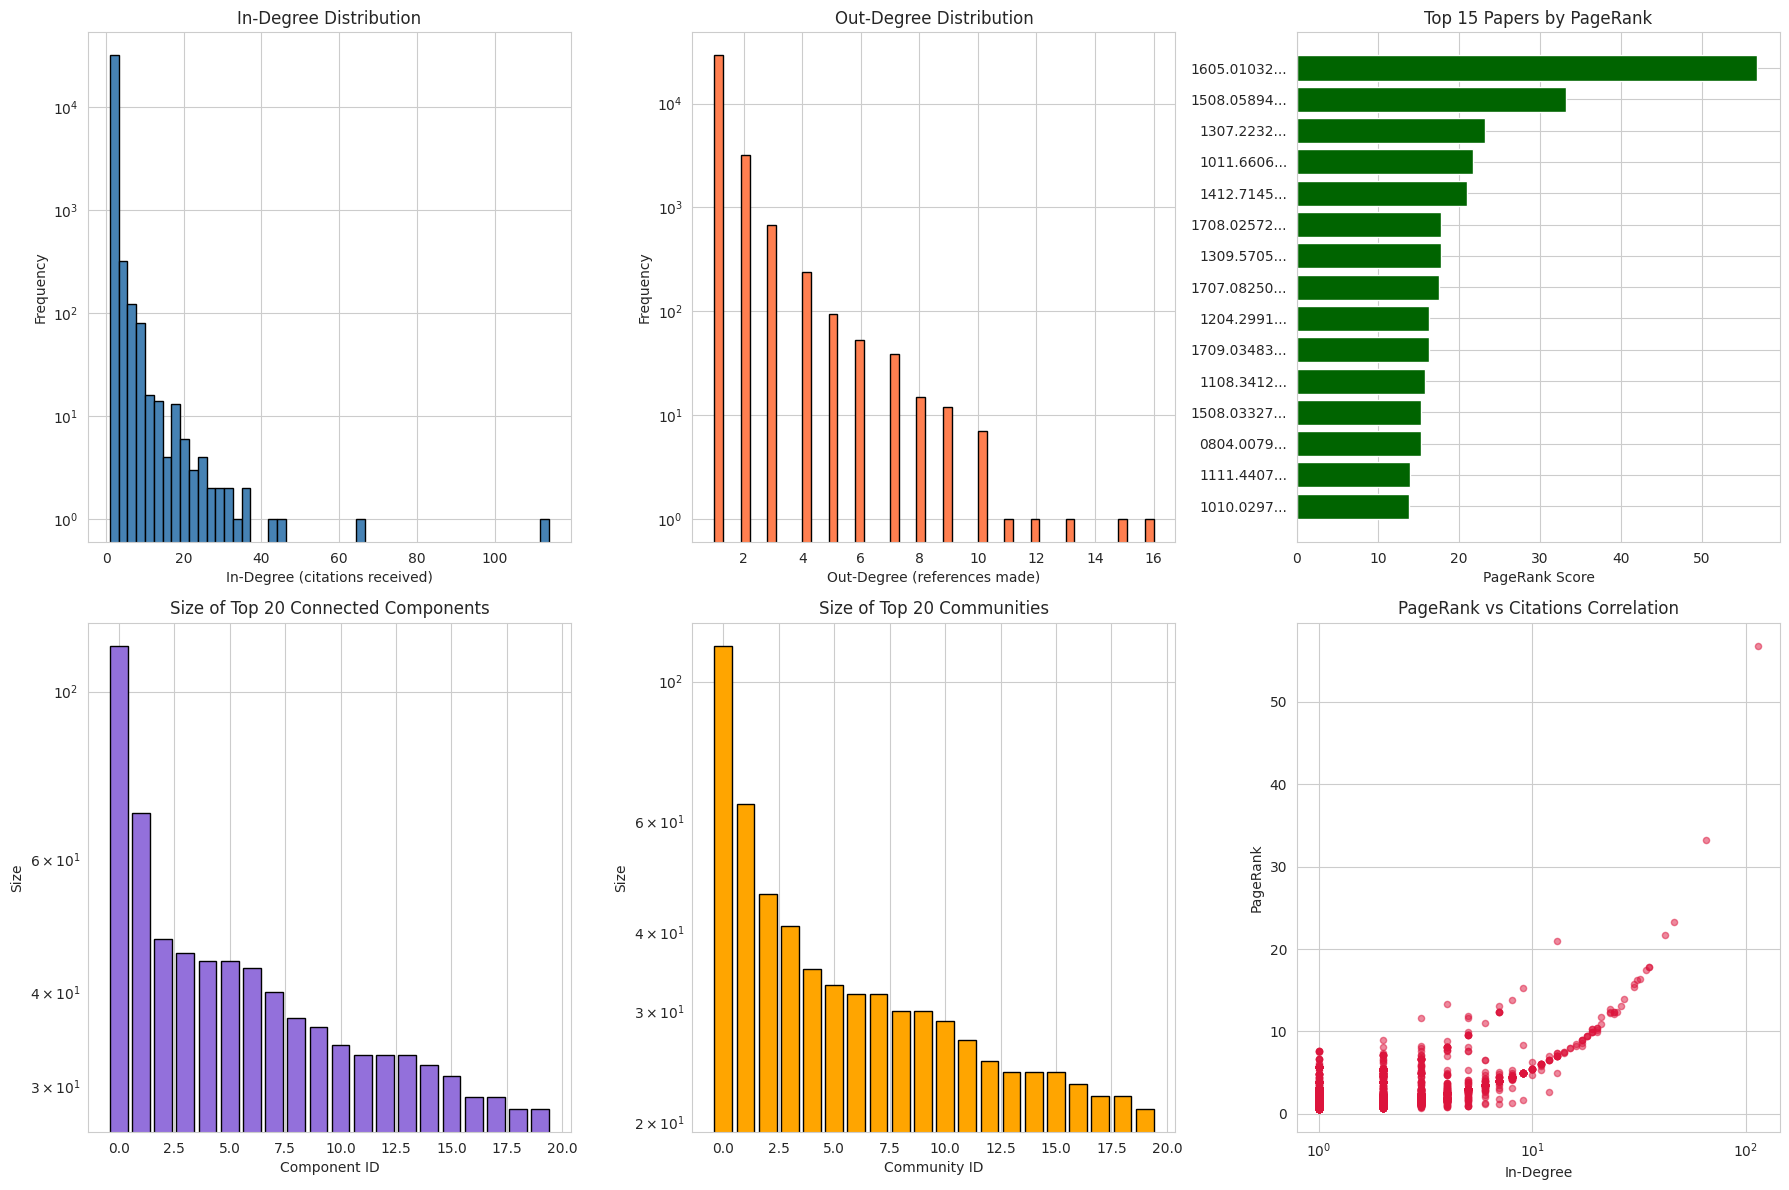

In [14]:
print("\n" + "="*70)
print("STEP 9: VISUALIZATIONS")
print("="*70)

# load data from HDFS for visualization
print("\nLoading data from HDFS for visualization...")
in_degrees_viz = spark.read.parquet("hdfs:///output/citation_graph/in_degrees").toPandas()
out_degrees_viz = spark.read.parquet("hdfs:///output/citation_graph/out_degrees").toPandas()

print("Data loaded successfully")

# get top 15 pagerank
top_pr_viz = spark.read.parquet("hdfs:///output/citation_graph/top_pagerank_with_metadata") \
    .limit(15).toPandas()

# get top 20 component sizes
comp_sizes_viz = spark.read.parquet("hdfs:///output/citation_graph/connected_components") \
    .groupBy("component").count().orderBy(col("count").desc()) \
    .limit(20).toPandas()

# get top 20 community sizes
comm_sizes_viz = spark.read.parquet("hdfs:///output/citation_graph/label_propagation") \
    .groupBy("label").count().orderBy(col("count").desc()) \
    .limit(20).toPandas()

# pagerank vs in-degree (join and collect all)
# we need to read in_degrees as spark df again for the join operation
pr_indeg_viz = spark.read.parquet("hdfs:///output/citation_graph/pagerank_results") \
    .join(spark.read.parquet("hdfs:///output/citation_graph/in_degrees"), "id") \
    .toPandas()

# configure matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# in-degree distribution
axes[0, 0].hist(in_degrees_viz['inDegree'], bins=50, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('In-Degree (citations received)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('In-Degree Distribution')
axes[0, 0].set_yscale('log')

# out-degree distribution
axes[0, 1].hist(out_degrees_viz['outDegree'], bins=50, edgecolor='black', color='coral')
axes[0, 1].set_xlabel('Out-Degree (references made)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Out-Degree Distribution')
axes[0, 1].set_yscale('log')

# top 15 papers by pagerank
axes[0, 2].barh(range(len(top_pr_viz)), top_pr_viz['pagerank'], color='darkgreen')
axes[0, 2].set_yticks(range(len(top_pr_viz)))
axes[0, 2].set_yticklabels([f"{row['id'][:10]}..." for _, row in top_pr_viz.iterrows()])
axes[0, 2].set_xlabel('PageRank Score')
axes[0, 2].set_title('Top 15 Papers by PageRank')
axes[0, 2].invert_yaxis()

# component sizes
axes[1, 0].bar(range(len(comp_sizes_viz)), 
               comp_sizes_viz['count'], 
               color='mediumpurple', edgecolor='black')
axes[1, 0].set_xlabel('Component ID')
axes[1, 0].set_ylabel('Size')
axes[1, 0].set_title('Size of Top 20 Connected Components')
axes[1, 0].set_yscale('log')

# community sizes (lpa)
axes[1, 1].bar(range(len(comm_sizes_viz)), 
               comm_sizes_viz['count'], 
               color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Community ID')
axes[1, 1].set_ylabel('Size')
axes[1, 1].set_title('Size of Top 20 Communities')
axes[1, 1].set_yscale('log')

# pagerank vs in-degree
axes[1, 2].scatter(pr_indeg_viz['inDegree'], pr_indeg_viz['pagerank'], 
                   alpha=0.5, s=20, color='crimson')
axes[1, 2].set_xlabel('In-Degree')
axes[1, 2].set_ylabel('PageRank')
axes[1, 2].set_title('PageRank vs Citations Correlation')
axes[1, 2].set_xscale('log')

plt.tight_layout()
plt.savefig('arxiv_graph_analysis.png', dpi=300, bbox_inches='tight')
print("\nVisualizations saved to 'arxiv_graph_analysis.png'")
plt.show()

The visualizations confirm the network's fragmented but more substantial structure compared to the filtered sample:

1. **Sparsity**: the 'In-Degree' and 'Out-Degree' histograms show steep declines with most papers having only 1-3 connections. However, the distribution extends to over 100 citations for in-degree and 16 references for out-degree, showing some highly connected nodes exist.
2. **Top influencers**: paper `1605.01032` clearly dominates with a PageRank score nearly double that of the second-ranked paper. The remaining top papers show more gradual score decreases, suggesting a tiered hierarchy of influence rather than isolated equal leaders.
3. **Community structure**: the 'Component' and 'Community' size charts reveal that the largest groups contain around 100-115 papers, with a sharp drop-off to smaller clusters. This confirms the network consists of a few moderately-sized communities surrounded by many small isolated groups.
4. **Influence correlation**: the scatter plot shows a strong positive correlation between citations and PageRank score, particularly for highly cited papers (10+ citations). The spread at lower citation counts indicates PageRank captures structural importance beyond simple popularity, as papers with similar citation counts can have vastly different PageRank scores.

### Analysis by category

In this final step, we aggregate the results by field in order to understand which areas carry the most weight. We extract the primary category from each paper and calculate the average PageRank score for that group. This allows us to see which specific areas tend to produce the most influential articles in this network.


STEP 10: ANALYSIS BY SCIENTIFIC CATEGORIES

Top 20 categories by average PageRank:
primary_category     mean  count
           cs.GL 3.865538      2
         stat.ME 1.508431    473
        q-bio.TO 1.455820     13
         stat.AP 1.263162    182
           cs.SC 1.243845     49
        q-fin.PR 1.238542     62
           cs.GR 1.235821     19
           cs.GT 1.225053    259
        astro-ph 1.217696    217
         math.CT 1.210611    155
           cs.ET 1.210244     42
         eess.SY 1.181445      5
           cs.MA 1.180306     48
         econ.GN 1.177419      2
         math.KT 1.172042    133
physics.class-ph 1.157590    108
           cs.AR 1.156074     66
         math.ST 1.150913    465
        q-fin.RM 1.137248     30
           cs.PF 1.132427     33

Graph saved to 'category_importance.png'


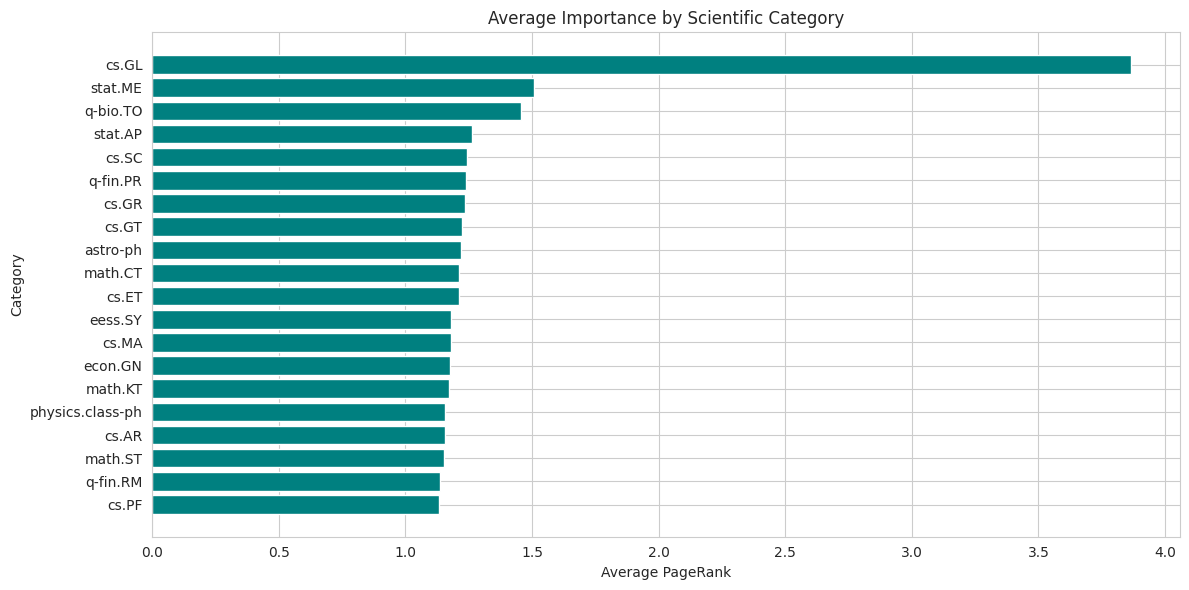

In [15]:
print("\n" + "="*70)
print("STEP 10: ANALYSIS BY SCIENTIFIC CATEGORIES")
print("="*70)

# load vertices and pagerank from HDFS
vertices_cat = spark.read.parquet("hdfs:///output/citation_graph/nodes_filtered")
pagerank_cat = spark.read.parquet("hdfs:///output/citation_graph/pagerank_results")

# extract primary category (distributed operation)
from pyspark.sql.functions import split
vertices_with_primary = vertices_cat.withColumn(
    'primary_category',
    split(col('categories'), ' ').getItem(0)
)

# merge with pagerank (distributed join)
pagerank_with_cat = pagerank_cat.join(
    vertices_with_primary.select('id', 'primary_category'),
    'id'
)

# calculate average pagerank by category (distributed aggregation)
category_pagerank = pagerank_with_cat.groupBy('primary_category').agg(
    F.mean('pagerank').alias('mean'),
    F.count('pagerank').alias('count')
).orderBy(col('mean').desc())

# get top 20 categories
top_categories = category_pagerank.limit(20).toPandas()

print("\nTop 20 categories by average PageRank:")
print(top_categories.to_string(index=False))

# visualization
plt.figure(figsize=(12, 6))
plt.barh(range(len(top_categories)), top_categories['mean'], color='teal')
plt.yticks(range(len(top_categories)), top_categories['primary_category'])
plt.xlabel('Average PageRank')
plt.ylabel('Category')
plt.title('Average Importance by Scientific Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('category_importance.png', dpi=300, bbox_inches='tight')
print("\nGraph saved to 'category_importance.png'")
plt.show()

The bar chart shows that Computer Science - General Literature (`cs.GL`) has the highest average PageRank score, but with only 2 papers this is not representative of a larger community.

Categories with substantial paper counts reveal more meaningful patterns: Statistical Methodology (stat.ME, 473 papers) and Mathematical Statistics (`math.ST`, 465 papers) maintain high average PageRank scores of 1.51 and 1.15 respectively, indicating that Statistics fields form well-connected and influential communities. 

Other notable categories include Computer Science Game Theory (`cs.GT`, 259 papers), Astrophysics (`astro-ph`, 217 papers), and Applied Statistics (`stat.AP`, 182 papers), all with scores above 1.2, suggesting active citation practices within these fields.

### Final summary

In [16]:
print("\n" + "="*70)
print("FINAL ANALYSIS SUMMARY")
print("="*70)

# load summary statistics from HDFS
num_nodes_filtered = spark.read.parquet("hdfs:///output/citation_graph/nodes_filtered").count()
num_edges_filtered = spark.read.parquet("hdfs:///output/citation_graph/edges_filtered").count()

# component statistics
comp_stats = spark.read.parquet("hdfs:///output/citation_graph/connected_components") \
    .groupBy("component").count().orderBy(col("count").desc()).limit(1).collect()
total_components = spark.read.parquet("hdfs:///output/citation_graph/connected_components") \
    .select("component").distinct().count()

# community statistics
comm_stats = spark.read.parquet("hdfs:///output/citation_graph/label_propagation") \
    .groupBy("label").count().orderBy(col("count").desc()).limit(1).collect()
total_communities = spark.read.parquet("hdfs:///output/citation_graph/label_propagation") \
    .select("label").distinct().count()

# top cited paper
top_cited_stats = spark.read.parquet("hdfs:///output/citation_graph/in_degrees") \
    .orderBy(col("inDegree").desc()).limit(1).collect()

# top pagerank
top_pr_stats = spark.read.parquet("hdfs:///output/citation_graph/pagerank_results") \
    .orderBy(col("pagerank").desc()).limit(1).collect()

print(f"""
GRAPH STATISTICS:
  - Papers analyzed: {num_nodes_filtered:,}
  - Total citations: {num_edges_filtered:,}
  - Average density: {num_edges_filtered/num_nodes_filtered:.2f} citations/paper
  
COMPONENTS AND COMMUNITIES:
  - Connected components: {total_components}
  - Size of main component: {comp_stats[0]['count']:,} papers
  - Detected communities (LPA): {total_communities}
  
MOST IMPORTANT PAPERS:
  - Most cited paper: {top_cited_stats[0]['inDegree']} citations
  - Max PageRank: {top_pr_stats[0]['pagerank']:.4f}
  
GENERATED FILES IN HDFS:
  - hdfs:///output/citation_graph/nodes_filtered - Filtered nodes
  - hdfs:///output/citation_graph/edges_filtered - Filtered edges
  - hdfs:///output/citation_graph/pagerank_results - PageRank results
  - hdfs:///output/citation_graph/connected_components - Components
  - hdfs:///output/citation_graph/label_propagation - Communities
  - hdfs:///output/citation_graph/in_degrees - Citation counts
  - hdfs:///output/citation_graph/out_degrees - Reference counts
  
LOCAL VISUALIZATIONS:
  - arxiv_graph_analysis.png - Main visualizations
  - category_importance.png - Category analysis
""")


FINAL ANALYSIS SUMMARY

GRAPH STATISTICS:
  - Papers analyzed: 60,068
  - Total citations: 39,867
  - Average density: 0.66 citations/paper
  
COMPONENTS AND COMMUNITIES:
  - Connected components: 24174
  - Size of main component: 115 papers
  - Detected communities (LPA): 48114
  
MOST IMPORTANT PAPERS:
  - Most cited paper: 114 citations
  - Max PageRank: 56.7654
  
GENERATED FILES IN HDFS:
  - hdfs:///output/citation_graph/nodes_filtered - Filtered nodes
  - hdfs:///output/citation_graph/edges_filtered - Filtered edges
  - hdfs:///output/citation_graph/pagerank_results - PageRank results
  - hdfs:///output/citation_graph/connected_components - Components
  - hdfs:///output/citation_graph/label_propagation - Communities
  - hdfs:///output/citation_graph/in_degrees - Citation counts
  - hdfs:///output/citation_graph/out_degrees - Reference counts
  
LOCAL VISUALIZATIONS:
  - arxiv_graph_analysis.png - Main visualizations
  - category_importance.png - Category analysis



### Close Spark session

In [17]:
# close spark session
print("\nClosing Spark session...")
spark.stop()
print("Session closed successfully")


Closing Spark session...
Session closed successfully
